In [2]:
from IPython.display import display, Javascript, HTML, clear_output
from ipywidgets import widgets, Output, interact
from ipywidgets.widgets import Dropdown
from datetime import datetime
from toggle import hide_toggle, hide_toggle2, hide_cell, show_all

# design the button
toggle_modules = widgets.Button(description='Modules Imported', button_style='success')


# cell show/hide to play around with
def hide_modules(b):
    with out1:
        clear_output()
        display(hide_toggle2(for_next=True))
        
        
out1 = Output()
display(out1)

toggle_modules.on_click(hide_modules)
display(toggle_modules)

display(Javascript('IPython.notebook.execute_cells_below()'))

<IPython.core.display.Javascript object>

Output()

Button(button_style='success', description='Modules Imported', style=ButtonStyle())

<IPython.core.display.Javascript object>

In [3]:
## Modules Imported ##

# Display
from IPython.display import display, Markdown as md, clear_output, HTML
from ipywidgets import Output, interact, fixed
from ipywidgets.widgets import Dropdown, interactive_output, VBox
from urllib.parse import quote_plus
from datetime import datetime, date

# APIs
from wikiwho_wrapper import WikiWho
from external.wikipedia import WikipediaDV, WikipediaAPI

# Data Processing
import pandas as pd

# Visualization
import qgrid
from visualization.actions_listener import ActionsListener
from visualization.conflicts_listener import ConflictsListener
from visualization.wordcloud_listener import WCListener
from utils.notebooks import get_date_slider_from_datetime
from metrics.conflict import ConflictManager
from utils.notebooks import get_next_notebook, get_previous_notebook

## Some Extensions ##
%load_ext autoreload
%autoreload 2
%store -r the_page

if 'the_page' not in locals():
    import pickle
    print("Loading default data...")
    the_page = pickle.load(open("data/the_page.p",'rb'))


In [4]:
display(md(f"# ***Page: {the_page['title']}***"))

# ***Page: 007***

Or you could also change the page:

In [5]:
wikipedia_dv = WikipediaDV(WikipediaAPI(domain='en.wikipedia.org'))

# the method that listens to the click event
def on_button_clicked(b):
    global the_page
    
    # use the out widget so the output is overwritten when two or more
    # searches are performed
    with out0:
        try:
            # query wikipedia
            search_result = wikipedia_dv.search_page(searchTerm.value)
            the_page = wikipedia_dv.get_page(search_result)
            %store the_page
            clear_output()
            display(md(f"The page that was found: **{the_page['title']}**"))
            display(md(f"Page id: **{the_page['page_id']}**"))

        except:
            clear_output()
            display(md(f'The page title *"{searchTerm.value}"* was not found'))

# by default display the last search
try:
    searchTerm = widgets.Text(the_page['title'], description='Page title:')
except:
    searchTerm = widgets.Text("The Camp of the Saints", description='Page title:')

display(searchTerm)

# create and display the button    
button = widgets.Button(description="Search")
display(button)

# the output widget is used to remove the output after the search field
out0 = Output()
display(out0)

# set the event
button.on_click(on_button_clicked)

# trigger the event with the default value
on_button_clicked(button)

Text(value='007', description='Page title:')

Button(description='Search', style=ButtonStyle())

Output()

---

# A. Article actions and conflict

The [WikiWho API](https://www.wikiwho.net/en/api/v1.0.0-beta/) tracks the changes to every token (words or special characters) on a Wikipedia page with at least 95% accuracy. It distinguishes every token in the document even when the string appears several times. E.g. "and" at the beginning of an article is a different token then "and" at the end of the article. See also [this figure](https://www.wikiwho.net/#technical_details).

That means that **not only edits** are counted, which can contain changes many different tokens, but *every single action to every single token* is recorded. Two actions can perfomed per token: i.e. **insertions** and **deletions** (a character change in a word, e.g. "dog" -> "dogs", is modeled as deletion of "dog" and the insertion of "dogs", two separate tokens). An **insertion** is also considered a **re-insertion** if the insertion has occured before; the only insertion of a token that is not a re-insertion is the first one. Similarly, a **deletion** is also considered a **re-deletion** if 
the deletion has occured before.

Formally, the token history can represented by a time-ordered sequence of actions 
*(a<sub>0</sub>, ..., a<sub>n</sub>)*; note that *a<sub>0+2i</sub>* is always an insertion and 
*a<sub>1+2i</sub>* is always a deletion for i ∈ ℕ.

---

***IMPORTANT:*** For articles with a long revision history, 
please allow for some time to load (see cog wheel symbol right of 'edit app') 
before interacting with the controls too often.

## A.1 Total actions per month and editor

**Columns description:**
- **total**: total number of actions (insertions, and deletions)
- **total_surv_48h**: total number of actions that survived at least 48 hours
- **total_persistent**:  total number of actions that survived until, at least, the end of the month
- **total_stopword_count**:  total number of actions that were performed in stop words

In [6]:
# create and display the button
button2 = widgets.Button(description="Get Total Actions")
display(button2)

# set the default max number of rows to 10 so the larger DataFrame we render don't take up to much space 
qgrid.set_grid_option('maxVisibleRows', 5)

def total_actions(b):
    global agg_actions
    global editors
    
    with out2:
        wikiwho = WikiWho(lng='en')
        agg_actions = wikiwho.dv.edit_persistence(the_page.page_id)

        # define total columns
        total_columns = ['total', 'total_surv_48h', 'total_persistent', 'total_stopword_count']

        # add columns with the total actions
        agg_actions = agg_actions.join(pd.DataFrame(
            agg_actions.loc[:,'adds':'adds_stopword_count'].values +\
            agg_actions.loc[:,'dels':'dels_stopword_count'].values +\
            agg_actions.loc[:,'reins':'reins_stopword_count'].values, 
            index=agg_actions.index, 
            columns=total_columns
        ))

        # the output widget is used to update the qgrid
        print("Downloading editor usernames (i.e. *editor* column)...")
        
        clear_output()
        # Grab user names from wikipedia and merge them to the editors_conflict dataframe
        wikipedia_dv = WikipediaDV(WikipediaAPI(domain='en.wikipedia.org'))
        editors = wikipedia_dv.get_editors(agg_actions['editor_id'].unique()).rename(columns = {
            'userid': 'editor_id'})

        # Merge the names of the editors to the aggregate actions dataframe
        display(md(f"***Page: {the_page['title']}***"))
        agg_actions = agg_actions.merge(editors[['editor_id', 'name']], on='editor_id')
        agg_actions.insert(3, 'editor', agg_actions['name'])
        agg_actions = agg_actions.drop(columns=['name'])
        agg_actions['editor'] = agg_actions['editor'].fillna("Unregistered")
       
        # url
        url_a = wikiwho.dv.api.base_editor + f'/page/{the_page.page_id}'
        display(md(f"Actions data can be found in:"))
        print(url_a)
                   
        display(qgrid.show_grid(agg_actions[['year_month', 'editor_id', 'editor'] + total_columns]))
        display(Javascript('Jupyter.notebook.execute_cells([11])'))

out2 = Output()
display(out2)

# set the event
button2.on_click(total_actions)

# trigger the event with the default value
total_actions(button2)

Button(description='Get Total Actions', style=ButtonStyle())

Output()

In [7]:
# design the button
toggle_cell = widgets.Button(description='Show/Hide The Code', button_style='success')

# cell show/hide to play around with
def hide_search(b):
    with out3:
        clear_output()
        display(hide_toggle2(for_next_next=True))
        display(Javascript('Jupyter.notebook.execute_cells([11])'))
        
out3 = Output()
display(out3)

toggle_cell.on_click(hide_search)
display(toggle_cell)

Output()

Button(button_style='success', description='Show/Hide The Code', style=ButtonStyle())

In [48]:
# hide the tutorial code output
html_hide_prev = """
                    <script>
                        $('div.cell.code_cell.rendered.selected').next().find('div.output').hide()
                    </script>
                """
display(HTML(html_hide_prev))

display(Javascript('Jupyter.notebook.execute_cells([16])'))

<IPython.core.display.Javascript object>

In [75]:
### ----------------------------------------------------------------------------------- ###
### TRY YOURSELF! THIS IS WHAT WILL HAPPEN WHEN YOU CLICK 'Get Total Actions' BUTTON ###
### ----------------------------------------------------------------------------------- ###

## This is the page you used ##
print('The page that is being used:', the_page['title'])

## Create a WikiWho instance, which is an API; and use 'edit_persistence' method to get ##
## monthly editons for given page id; more details see:                                 ##
## https://github.com/gesiscss/wikiwho_wrapper/blob/master/wikiwho_wrapper/api.py       ##
## https://github.com/gesiscss/wikiwho_wrapper/blob/master/wikiwho_wrapper/wikiwho.py   ##
wikiwho_api = WikiWho(lng='en')
total_actions = wikiwho_api.dv.edit_persistence(the_page['page_id'])

## url ##
url_actions = wikiwho_api.dv.api.base_editor + f'/page/{the_page.page_id}'
print("Actions data can be found in:", url_actions)

## Convert some columns' names to what we could understand ##
total_columns_names = ['total', 'total_surv_48h', 'total_persistent', 'total_stopword_count']

## Add all actions together and merge them into one aggregation dataframe.
total_actions = total_actions.join(pd.DataFrame(
    total_actions.loc[:,'adds':'adds_stopword_count'].values +\
    total_actions.loc[:,'dels':'dels_stopword_count'].values +\
    total_actions.loc[:,'reins':'reins_stopword_count'].values, 
    index=total_actions.index, 
    columns=total_columns_names
))

## Only editors id? No, we still want to know their names. Use WikipediaAPI to achieve ##
## this. More details see:                                                             ##
## https://github.com/gesiscss/wikiwho_demo/blob/master/external/wikipedia.py          ##
wikipediadv_instance = WikipediaDV(WikipediaAPI(domain='en.wikipedia.org'))

# Unique editor's id for getting their names
unique_ids = total_actions['editor_id'].unique()

# Grab editors' names
grabbed_names = wikipediadv_instance.get_editors(unique_ids).rename(columns = {'userid': 'editor_id'})

## Merge the names of editors to the total actions dataframe ##

# Merge on editors ids
total_actions = total_actions.merge(grabbed_names[['editor_id', 'name']], on='editor_id')

# Adjust the column position and fill NaN by 'Unregistered'
total_actions.insert(3, 'editor', total_actions['name'])
total_actions = total_actions.drop(columns=['name'])
total_actions['editor'] = total_actions['editor'].fillna("Unregistered")

## Display the dataframe using interactive grid, you could learn more through the doc: ##
## https://qgrid.readthedocs.io/en/latest/                                             ##
display(qgrid.show_grid(total_actions[['year_month', 'editor_id', 'editor'] + total_columns_names]))

The page that is being used: 007
Actions data can be found in: https://api.wikiwho.net/en/edit_persistence/v1.0.0-beta/page/2655587


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

## A.2. Visualization of actions per month

In the following graph you can select the *date range* and *granularity* (yearly, montly) 
of the timeline (X-axis), and plot any of the follow counts in the black, red, blue and green lines:
   
- **adds**: number of first-time insertions
- **adds_surv_48h**: number of insertions for the first time that survived at least 48 hours
- **adds_persistent**:  number of insertions for the first time that survived until, at least, the end of the month
- **adds_stopword_count**:  number of insertions that were stop words
- **dels**: number of deletions
- **dels_surv_48h**: number of deletions that were not resinserted in the next 48 hours
- **dels_persistent**: number of deletions that were not resinserted until, at least, the end of the month
- **dels_stopword_count**: number of deletions that were stop words
- **reins**: number of reinsertions
- **reins_surv_48h**: number of reinsertions that survived at least 48 hours
- **reins_persistent**: number of reinsertionsthat survived until the end of the month
- **reins_stopword_count**: number of reinsertionsthat were stop words

**What do these actions/counts mean?** For instance, if you see 10 "adds" in a month, but only 4 "adds_surv_48h", 10 completely new tokens/words have been added to the article, but only 4 of them stayed in the article for more than 2 days, which usually means the other 6 are gone for good. If "dels" are performed and don't survive, that means that these deletions have been undone, i.e., the deleted tokens have been put back. I.e., these are measurements of the longevity and stability of edit actions done to the article. 

In [10]:
# create and display the button
button2 = widgets.Button(description="Show Actions Details")
display(button2)

def on_click_details(b):
    with out4:
        clear_output()
        display(md(f"***Page: {the_page['title']}***"))
        # Convert to datetime
        agg_actions['year_month'] = pd.to_datetime(agg_actions['year_month'])

        # Group the data by year month and page (drop the editor information)
        agg_actions.drop('editor_id', axis=1).groupby(['year_month','page_id']).sum().reset_index()

        # Listener
        listener = ActionsListener(agg_actions)
        action_types = (agg_actions.columns[4:16]).values.tolist()

        # Visualization
        interact(listener.listen,
                 _range = get_date_slider_from_datetime(agg_actions['year_month']),
                 editor=fixed('All'),
                 granularity=Dropdown(options=['Yearly', 'Monthly'], value='Yearly'),
                 black=Dropdown(options=action_types, value='adds'), 
                 red=Dropdown(options= ['None'] + action_types, value='dels'),
                 green=Dropdown(options= ['None'] + action_types, value='None'), 
                 blue=Dropdown(options= ['None'] + action_types, value='None'))

        display(Javascript('Jupyter.notebook.execute_cells([17])'))
    
out4 = Output()
display(out4)

# set the event
button2.on_click(on_click_details)

# trigger the event with the default value
on_click_details(button2)

Button(description='Show Actions Details', style=ButtonStyle())

Output()

In [11]:
# design the button
toggle_cell = widgets.Button(description='Show/Hide The Code', button_style='success')

# cell show/hide to play around with
def hide_search(b):
    with out5:
        clear_output()
        display(hide_toggle2(for_next_next=True))
        display(Javascript('Jupyter.notebook.execute_cells([17])'))
        
out5 = Output()
display(out5)

toggle_cell.on_click(hide_search)
display(toggle_cell)

Output()

Button(button_style='success', description='Show/Hide The Code', style=ButtonStyle())

In [51]:
# hide the tutorial code output
html_hide_prev = """
                    <script>
                        $('div.cell.code_cell.rendered.selected').next().find('div.output').hide()
                    </script>
                """
display(HTML(html_hide_prev))

display(Javascript('Jupyter.notebook.execute_cells([23])'))

<IPython.core.display.Javascript object>

In [37]:
### ----------------------------------------------------------------------------------- ###
### TRY YOURSELF! THIS IS WHAT WILL HAPPEN WHEN YOU CLICK 'Show Actions Details' BUTTON ###
### ----------------------------------------------------------------------------------- ###

## This is the page you used ##
print('The page that is being used:', the_page['title'])

## Continue to use our data from A.1; first convert the date to the type datetime ##
total_actions['year_month'] = pd.to_datetime(total_actions['year_month'])

## visualization, core visual code lies in ActionsListener, then the interact function    ##
## make it interactive, mode details see:                                                 ##
## https://github.com/gesiscss/wikiwho_demo/blob/master/visualization/actions_listener.py ##

# Define a ActionsListener instance
actions_listener = ActionsListener(total_actions)

# Which types do those actions have?
actions_types = (total_actions.columns[4:16]).values.tolist()

# Visualization: try yourself by coding!
begin_date = date(2002, 3, 1)
end_date = date(2019, 4, 1)
editor_name = 'All'
frequency = 'Yearly' # 'Monthly'
black_line = 'adds' # Choose one from 'actions_types'. Note that 'black_line doesn't have 'None' option but others have.
red_line = 'dels'
blue_line = 'None'
green_line = 'None'

actions_listener.listen(
    _range = (begin_date, end_date),
    editor = editor_name,
    granularity = frequency,
    black = black_line,
    red = red_line,
    blue = blue_line,
    green = green_line
)

The page that is being used: 007


---

## A.3 Page Conflict

Our measurement of ***conflict*** for single tokens is taken from [Flöck et al.](https://arxiv.org/abs/1703.08244):


* (1)  The main idea is to count how often a token  - after being created (added) the first time -  was being deleted, re-inserted, re-deleted, re-inserted, and so on; which would often happen in case two editors disagree on the token's justification to be in the text. 
* (2) Only the **re-**deletions and **re-**insertions are counted, since up to the first delete it could be a simple correction that didn't trigger a reponse - this wouldn't indicate conflict. 
* (3) The **"re-"** actions are only counted if they alternate between different editors and don't come from the same editor twice or more in a row - as the latter would simply indicate self-corrections. 
* (4) In a last step, each re-insertion/re-deletion interaction gets a higher weight the faster it occurs (see [Flöck et al.](https://arxiv.org/abs/1703.08244) for the exact formula).

The total conflict of a page is the sum of all the conflict scores of all actions with 
conflict (or conflict actions). 

This total conflict can be normalized if the sum is divided by the number of 
actions that could potentially be counted as conflict (elegible actions, i.e **"re-"** actions that have occurred at 
least twice).




In the following graph you can select the *date range* and *granularity* (yearly, monthly) 
of the timeline (X-axis), and plot any of the following counts in the black and red lines:
   
- **Total**: total number of actions (insertions, and deletions)
- **Total_surv_48h**: total number of actions that survived at least 48 hours
- **Total_persistent**: total number of actions that survived until, at least, the end of the month
- **Total_stopword_count**: total number of actions that were performed in stop words
- **Total Elegible Actions**: the total number of elegible actions
- **Conflict count**: the total number of conflicts
- **Number of Revisions**: the total number of revisions/edits
- **Conflict Score**: the sum of conflict scores of all actions divided by the number of elegible actions
- **Absolute Conflict Score**: the sum of conflict scores of all actions (without division)
- **Conflict Ratio**: the count of all conflicts divided by the number of elegible actions

In [14]:
# create and display the button
button2 = widgets.Button(description="Show Page Conflict")
display(button2)

def on_click_conflict(b):
    with out6:
        clear_output()
        display(md(f"***Page: {the_page['title']}***"))
        
        # Visualization
        listener = ConflictsListener(agg_actions)

        metrics = ['Total', 'Total_surv_48h', 'Total_persistent', 'Total_stopword_count',
                   'Total Elegible Actions', 'Number of Conflicts', 'Number of Revisions',
                   'Conflict Score', 'Absolute Conflict Score', 'Conflict Ratio']
        conflict_score = agg_actions.conflict.sum() / agg_actions.elegibles.sum()
        display(md(f'**Page conflict score: {conflict_score}**'))

        # Visualization
        if (conflict_score != 0):
            interact(listener.listen,
                     _range = get_date_slider_from_datetime(agg_actions['year_month']),
                     granularity=Dropdown(options=['Yearly', 'Monthly'], value='Monthly'),
                     black=Dropdown(options=metrics, value='Conflict Score'),
                     red=Dropdown(options= ['None'] + metrics, value='None'))
        display(Javascript('Jupyter.notebook.execute_cells([24])'))
    

out6 = Output()
display(out6)

# set the event
button2.on_click(on_click_conflict)

# trigger the event with the default value
on_click_conflict(button2)

Button(description='Show Page Conflict', style=ButtonStyle())

Output()

In [15]:
# design the button
toggle_cell = widgets.Button(description='Show/Hide The Code', button_style='success')

# cell show/hide to play around with
def hide_search(b):
    with out5:
        clear_output()
        display(hide_toggle2(for_next_next=True))
        display(Javascript('Jupyter.notebook.execute_cells([24])'))
        
out5 = Output()
display(out5)

toggle_cell.on_click(hide_search)
display(toggle_cell)

Output()

Button(button_style='success', description='Show/Hide The Code', style=ButtonStyle())

In [54]:
# hide the tutorial code output
html_hide_prev = """
                    <script>
                        $('div.cell.code_cell.rendered.selected').next().find('div.output').hide()
                    </script>
                """
display(HTML(html_hide_prev))

display(Javascript('Jupyter.notebook.execute_cells([29])'))

<IPython.core.display.Javascript object>

In [39]:
### ----------------------------------------------------------------------------------- ###
### TRY YOURSELF! THIS IS WHAT WILL HAPPEN WHEN YOU CLICK 'Show Page Conflict' BUTTON   ###
### ----------------------------------------------------------------------------------- ###

## This is the page you used ##
print('The page that is being used:', the_page['title'])

## Continue to use our data from A.2; calculate the Conflict Score definded as above ##
conflict_sc = total_actions.conflict.sum() / total_actions.elegibles.sum()
print('Page conflict score is:', conflict_sc)

## visualization, core visual code lies in ConflictsListener, then the interact function    ##
## make it interactive, mode details see:                                                   ##
## https://github.com/gesiscss/wikiwho_demo/blob/master/visualization/conflicts_listener.py ##

# First check whether the page conflict score is zero
if conflict_sc != 0:
    # Define a ConflictsListener instance
    conflicts_listener = ConflictsListener(total_actions)

    # Set parameters
    begin_date = date(2005, 3, 1)
    end_date = date(2019, 6, 1)
    frequency = 'Yearly' # 'Monthly'
    
    # The metrics we need:
    # ['Total', 'Total_surv_48h', 'Total_persistent', 'Total_stopword_count',
    #  'Total Elegible Actions', 'Number of Conflicts', 'Number of Revisions',
    #  'Conflict Score', 'Absolute Conflict Score', 'Conflict Ratio', ('None')]
    # Note: only 'red_line' has 'None' option.
    black_line = 'Conflict Score'
    red_line = 'None'
    
    conflicts_listener.listen(
        _range = (begin_date, end_date),
        granularity = frequency,
        black = black_line,
        red = red_line
    )

The page that is being used: 007
Page conflict score is: 0.475866278160594


---

## A.4 Editor Conflict Score

We can also calculate the conflict score for each individual editor. The
table below presents the conflict score and other related  metrics per editor (*editor_id* and *editor*
column):

- **conflicts**: the total number of conflicts
- **elegibles**: the total number of elegible actions performed by the editor
- **conflict**: the sum of conflict scores of all actions divided by the number of elegible actions

In [18]:
# create and display the button
button2 = widgets.Button(description="Conflict By Editor")
display(button2)

def on_click_editor(b):
    global editors_conflicts
    with out7:
        clear_output()
        display(md(f"***Page: {the_page['title']}***"))
                   
        editors_conflicts = agg_actions.groupby(pd.Grouper(
                    key='editor_id')).agg({'conflicts': 'sum', 'elegibles': 'sum', 'conflict': 'sum'}).reset_index()
        editors_conflicts['conflict'] = (editors_conflicts['conflict']/editors_conflicts['elegibles'])
        if len(editors_conflicts) > 0:
            editors_conflicts = editors[['editor_id', 'name']].merge(editors_conflicts.dropna(), 
                                                        right_index=True, on='editor_id').set_index('editor_id')
            qg_obj = qgrid.show_grid(editors_conflicts.dropna())
            display(qg_obj)
            display(Javascript('Jupyter.notebook.execute_cells([30])'))
                   
        else:
            display(md(f'**There is no Conflict Scores**')) 
            editors_conflicts = None
            
out7 = Output()
display(out7)

# set the event
button2.on_click(on_click_editor)

# trigger the event with the default value
on_click_editor(button2)

Button(description='Conflict By Editor', style=ButtonStyle())

Output()

In [19]:
# design the button
toggle_cell = widgets.Button(description='Show/Hide The Code', button_style='success')

# cell show/hide to play around with
def hide_search(b):
    with out8:
        clear_output()
        display(hide_toggle2(for_next_next=True))
        display(Javascript('Jupyter.notebook.execute_cells([30])'))
        
out8 = Output()
display(out8)

toggle_cell.on_click(hide_search)
display(toggle_cell)

Output()

Button(button_style='success', description='Show/Hide The Code', style=ButtonStyle())

In [56]:
# hide the tutorial code output
html_hide_prev = """
                    <script>
                        $('div.cell.code_cell.rendered.selected').next().find('div.output').hide()
                    </script>
                """
display(HTML(html_hide_prev))

display(Javascript('Jupyter.notebook.execute_cells([35])'))

<IPython.core.display.Javascript object>

In [61]:
### ----------------------------------------------------------------------------------- ###
### TRY YOURSELF! THIS IS WHAT WILL HAPPEN WHEN YOU CLICK 'Conflict By Editor' BUTTON   ###
### ----------------------------------------------------------------------------------- ###

## This is the page you used ##
print('The page that is being used:', the_page['title'])

## Continue to use our data from A.2; sum 'conflicts', 'elegibles' and 'conflict' (absolute) up by editors ##
conflicts_by_editors = total_actions.groupby(pd.Grouper(
                            key='editor_id')).agg({'conflicts': 'sum', 'elegibles': 'sum', 'conflict': 'sum'}).reset_index()

## Convert 'conflict' (absolute) to conflict ##
conflicts_by_editors['conflict'] = (conflicts_by_editors['conflict'] / conflicts_by_editors['elegibles'])

## If there are conflicts, then display it using qgrid ##
if len(conflicts_by_editors) > 0:
    conflicts_by_editors = grabbed_names[['editor_id', 'name']].merge(conflicts_by_editors.dropna(), 
                                                    right_index=True, on='editor_id').set_index('editor_id')
    qg_obj = qgrid.show_grid(conflicts_by_editors.dropna())
    display(qg_obj)
else:
    display(md(f'**There is no Conflict Scores**')) 
    conflicts_by_editors = None

The page that is being used: 007


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

## B.1 Conflict score of each singular action

In the following table, all the actions that are in conflict are presented, and a conflict score
is presented per action. The importance of the conflict can be meassure by considering the seconds t that 
have passed since the last action on the same token has occured (`time_diff_secs` column). A score to 
meassure conflict is calculated based on t with the following formula: 1 / log<sub>3600</sub>(t+2). 
Thus, *undo* actions are weighted higher than the original time in seconds when the *t* is less than an hour.
For details, please refer to [Flöck et al, 2017](https://arxiv.org/abs/1703.08244).
**Columns description:**
- **token**: the string of the token that is being tracked
- **token_id**: the id of the token that is being tracked
- **rev_id**: the revision id in which the action (insertion or deletion) happen
- **editor_id**: the id of the editor that inserted the token (if starts with **0|**, it means that
the editor is not registered, and the ip is displayed instead
- **time_diff_secs**: seconds that have passed since the last action on the same token has occured
- **conflict**: a score to meassure conflict that is calculated based on the `time_diff_secs` 
with the following formula: *1 / log<sub>3600</sub>(time_diff_secs + 2)*. For details, please refer to 
[Flöck et al, 2017](https://arxiv.org/abs/1703.08244)

In [22]:
# create and display the button
button2 = widgets.Button(description="Conflict By Action")
display(button2)

def on_click_actions(b):
    global calculator
    with out9:
        clear_output()
        # create the api
        wikiwho = WikiWho(lng='en')

        # Get the content and revisions from the wikiwho api
        display(md("Downloading all_content from the WikiWhoApi..."))
        all_content = wikiwho.dv.all_content(the_page['page_id'])

        display(md("Downloading revisions from the WikiWhoApi..."))
        revisions = wikiwho.dv.rev_ids_of_article(the_page['page_id'])

        clear_output()

        # call the calculator
        calculator = ConflictManager(all_content, revisions)
        calculator.calculate()
        clear_output()

        display(md(f"***Page: {the_page['title']}***"))
        # display the tokens, the difference in seconds and its corresponding conflict score
        conflicts = calculator.conflicts.copy()
        conflicts['time_diff_secs'] = conflicts['time_diff'].dt.total_seconds()

        if len(conflicts) > 0:
            display(qgrid.show_grid(conflicts[[
                'action', 'token', 'token_id', 'rev_id', 
                'editor', 'time_diff_secs', 'conflict']].rename(columns={
                'editor': 'editor_id'}).sort_values('conflict', ascending=False)))
        else:
            display(md(f'**There are no conflicting tokens in this page.**'))
            display(HTML(f'<a href="{get_previous_notebook()}" target="_blank">Go back to the previous workbook</a>'))
                   
        display(Javascript('Jupyter.notebook.execute_cells([36])'))
                   
out9 = Output()
display(out9)

# set the event
button2.on_click(on_click_actions)

# trigger the event with the default value
on_click_actions(button2)

Button(description='Conflict By Action', style=ButtonStyle())

Output()

In [23]:
# design the button
toggle_cell = widgets.Button(description='Show/Hide The Code', button_style='success')

# cell show/hide to play around with
def hide_search(b):
    with out10:
        clear_output()
        display(hide_toggle2(for_next_next=True))
        display(Javascript('Jupyter.notebook.execute_cells([36])'))
        
out10 = Output()
display(out10)

toggle_cell.on_click(hide_search)
display(toggle_cell)

Output()

Button(button_style='success', description='Show/Hide The Code', style=ButtonStyle())

In [58]:
# hide the tutorial code output
html_hide_prev = """
                    <script>
                        $('div.cell.code_cell.rendered.selected').next().find('div.output').hide()
                    </script>
                """
display(HTML(html_hide_prev))

display(Javascript('Jupyter.notebook.execute_cells([41])'))

<IPython.core.display.Javascript object>

In [67]:
### ----------------------------------------------------------------------------------- ###
### TRY YOURSELF! THIS IS WHAT WILL HAPPEN WHEN YOU CLICK 'Conflict By Action' BUTTON   ###
### ----------------------------------------------------------------------------------- ###

## Get the content and revisions from the wikiwho api ##
page_content = wikiwho_api.dv.all_content(the_page['page_id'])
page_revisions = wikiwho_api.dv.rev_ids_of_article(the_page['page_id'])

## Call the calculator, you could learn more about it through               ##
## https://github.com/gesiscss/wikiwho_demo/blob/master/metrics/conflict.py ##
conflict_calculator = ConflictManager(page_content, page_revisions)
conflict_calculator.calculate()
clear_output()

## This is the page you used ##
print('The page that is being used:', the_page['title'])

## Display the tokens, the difference in seconds and its corresponding conflict score                 ##
## Pandas.Series.dt: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.dt.html ##
token_conflicts = conflict_calculator.conflicts.copy()
token_conflicts['time_diff_secs'] = token_conflicts['time_diff'].dt.total_seconds()

## Display using qgrid ##
if len(token_conflicts) > 0:
    display(qgrid.show_grid(token_conflicts[[
        'action', 'token', 'token_id', 'rev_id', 
        'editor', 'time_diff_secs', 'conflict']].rename(columns={
        'editor': 'editor_id'}).sort_values('conflict', ascending=False)))
else:
    display(md(f'**There are no conflicting tokens in this page.**'))
    display(HTML(f'<a href="{get_previous_notebook()}" target="_blank">Go back to the previous workbook</a>'))

The page that is being used: 007


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

---

## B.2 Most frequent conflicting token strings

The WordCloud displays the most common conflicting token strings, i.e. words (token strings) 
with the most actions that have conflict. The size of the token string in the WordCloud indicates frequency 
of actions.
In the controls you can select the *date range*, the type of *action* (insertion or deletion), and the 
*source*. The *source* can be any of the following:
-   **Only Conflicts**: use only the actions that are in conflict.
-   **Elegible Actions**: use only the actions that can potentially enter into conflict, i.e. actions 
that have occurred at least twice, e.g. the token x has been inserted twice (which necessarily implies 
it was remove once), the token x has been deleted twice (which necessarily implies it was inserted twice) 
-   **All Actions**: use all tokens regardles conflict

In [26]:
# create and display the button
button2 = widgets.Button(description="Show WordCloud")
display(button2)

def on_click_wc(b):
    with out11:
        clear_output()
        display(md(f"***Page: {the_page['title']}***"))
        # listener
        listener = WCListener(sources = {
            'All actions': calculator.all_actions,
            'Elegible Actions': calculator.elegible_actions,
            'Only Conflicts': calculator.conflicts
        })

        # visualization
        _range=get_date_slider_from_datetime(calculator.all_actions['rev_time'])
        source=Dropdown(options=list(listener.sources.keys()), value='Only Conflicts', description='Source (*)')
        action=Dropdown(options=['Both', 'Just Insertions', 'Just Deletions'], value='Both', description='Action')
        editor=fixed('All')

        out = interactive_output(listener.listen, {
                 '_range': _range,
                 'source': source,
                 'action': action,
                 'editor': editor})

        display(VBox([_range, action, source, out]))
        display(Javascript('Jupyter.notebook.execute_cells([42])'))

out11 = Output()
display(out11)

# set the event
button2.on_click(on_click_wc)

# trigger the event with the default value
on_click_wc(button2)

Button(description='Show WordCloud', style=ButtonStyle())

Output()

In [27]:
# design the button
toggle_cell = widgets.Button(description='Show/Hide The Code', button_style='success')

# cell show/hide to play around with
def hide_search(b):
    with out12:
        clear_output()
        display(hide_toggle2(for_next_next=True))
        display(Javascript('Jupyter.notebook.execute_cells([42])'))
        
out12 = Output()
display(out12)

toggle_cell.on_click(hide_search)
display(toggle_cell)

Output()

Button(button_style='success', description='Show/Hide The Code', style=ButtonStyle())

In [59]:
# hide the tutorial code output
html_hide_prev = """
                    <script>
                        $('div.cell.code_cell.rendered.selected').next().find('div.output').hide()
                    </script>
                """
display(HTML(html_hide_prev))

The page that is being used: 007
Time range from 2005-03-01 to 2015-07-04


**Only top 100 most frequent words displayed.**

### The below token conflicts ocurred in a total of 1 revisions:

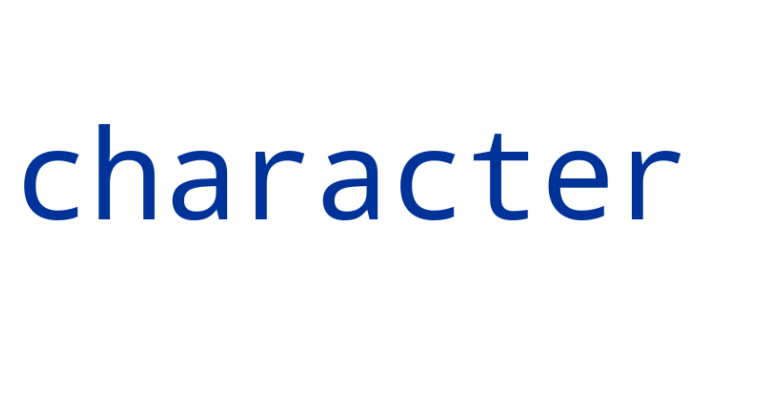

In [73]:
### ----------------------------------------------------------------------------------- ###
### TRY YOURSELF! THIS IS WHAT WILL HAPPEN WHEN YOU CLICK 'Show WordCloud' BUTTON       ###
### ----------------------------------------------------------------------------------- ###

## This is the page you used ##
print('The page that is being used:', the_page['title'])

## WordCloud, core visual code lies in WCListener, then the interact function               ##
## make it interactive, mode details see:                                                   ##
## https://github.com/gesiscss/wikiwho_demo/blob/master/visualization/wordcloud_listener.py ##

# Create a WCListener instance, continue to use our data from B.1;
wclistener = WCListener(sources = {
    'All actions': conflict_calculator.all_actions,
    'Elegible Actions': conflict_calculator.elegible_actions,
    'Only Conflicts': conflict_calculator.conflicts
})

# visualization
begin_date = date(2005, 3, 1)
end_date = date(2015, 7, 4)
actions_source='Only Conflicts' # 'Elegible Actions', 'All actions'
action_type='Both' # 'Just Insertions', 'Just Deletions'
editor='All'

print('Time range from', begin_date.strftime("%Y-%m-%d"), 'to', end_date.strftime("%Y-%m-%d"))
wclistener.listen(
     _range=(begin_date, end_date),
     source=actions_source,
     action=action_type,
     editor=editor)

In [30]:
%store agg_actions
%store calculator
%store editors_conflicts

clear_output()
# if len(editors_conflicts) > 0:
#     display(HTML(f'<a href="{get_next_notebook()}" target="_blank">Go to next workbook</a>'))
# else:
#     display(HTML(f'<a href="{get_previous_notebook()}" target="_blank">Go back to the previous workbook</a>'))


In [32]:
# Run turorial cells and hide their outputs by default.
display(Javascript('Jupyter.notebook.execute_cells([10])'))

<IPython.core.display.Javascript object>